In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.ContinuousValuedOOM import ContinuousValuedOOM
from src.oom.observable import *
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import scipy as sp

from IPython import display
# hdisplay = display.display("", display_id=True)

In [8]:
membership_fns = []

n_obs = 6
arg_sum = 128

for idx in range(1, n_obs + 1):
    offset = arg_sum / 2 * (n_obs + 1 - 2*idx) / (n_obs + 1)
    athis = arg_sum / 2 - offset
    bthis = arg_sum / 2 + offset
    
    pdf = sp.stats.beta(a = athis, b = bthis, loc = 0, scale = 1)
    membership_fns.append(pdf)

In [9]:
alphabet_size = n_obs
dimension = 10
sparsity = 0.9

oom_disc = DiscreteValuedOOM.from_sparse(
    alphabet_size = alphabet_size,
    dimension = dimension,
    density = 1 - sparsity,
    deterministic_functional = False,
    stationary_state = False,
    seed = None
)
oom_cont = ContinuousValuedOOM(
    dim = oom_disc.dim,
    linear_functional = oom_disc.lin_func,
    operators = oom_disc.operators,
    start_state = oom_disc.start_state,
    membership_functions = membership_fns,
)

In [10]:
generation_cont = oom_cont.generate(10000)

In [146]:
def plot_sequence(axs, generation_cont, n_obs):
    ser = pd.Series([obs.uid for obs in generation_cont.sequence])
    ser = ser.value_counts(normalize = True)
    ser = ser.sort_index(key = lambda x: x.str.ljust(5, 'z'))
    
    axs[0].bar(
        x = range(1, len(ser.index) + 1),
        height = ser
    )
    axs[0].set_xticks(
        ticks = range(1, len(ser.index) + 1),
        labels = list(ser.index)
    )
    
    
    axs[1].hist(
        generation_cont.sequence_cont,
        bins = 100,
        density = True,
        histtype = 'step',
        linewidth = 2,
        zorder = -5,
    )
    
    support = np.linspace(0, 1, 1000)
    x_vlines = np.linspace(0, 1, (n_obs + 1) + 1, endpoint = True)[1 : -1]

    for idx, xv in zip(range(1, n_obs + 1), x_vlines):
        axs[1].axvline(xv, color = 'r', linewidth = 0.5, linestyle = (0, (20, 20)))
        
        offset = arg_sum / 2 * (n_obs + 1 - 2*idx) / (n_obs + 1)
        athis = arg_sum / 2 - offset
        bthis = arg_sum / 2 + offset
        color = np.array([athis, arg_sum / 2, bthis])
        color = color / np.linalg.norm(color)
        
        pdf = oom_cont.membership_fns[idx - 1].pdf(support) / n_obs
        axs[1].plot(support, pdf, linewidth = 1, color = color)
    axs[1].set_xlim([0, 1])
    
    axs[2].scatter(
        x = generation_cont.sequence_cont[:-1],
        y = generation_cont.sequence_cont[1:],
        s = 2,
        alpha = 0.5
    )
    axs[2].set_box_aspect(1)
    axs[2].set_xlim([0, 1])
    axs[2].set_ylim([0, 1])


def plot_ellipses(ax, weights, means, covars, cmap):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(max(0.4, 0.8 * weights[n] / max(weights)))
        ell.set_facecolor(cmap(n / means.shape[0]))
        ax.add_artist(ell)


def plot_results(ax, estimator, X, y, colors, cmap, title, xlab, ylab, return_data = False):
    ax.set_title(title)
    
    data = ax.scatter(
        X[:, 0], X[:, 1],
        s = 2, marker = 'o', color = colors[1:], alpha = 0.4
    )
    if estimator is not None:
        plot_ellipses(ax, estimator.weights_, estimator.means_, estimator.covariances_, cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    if return_data:
        return data

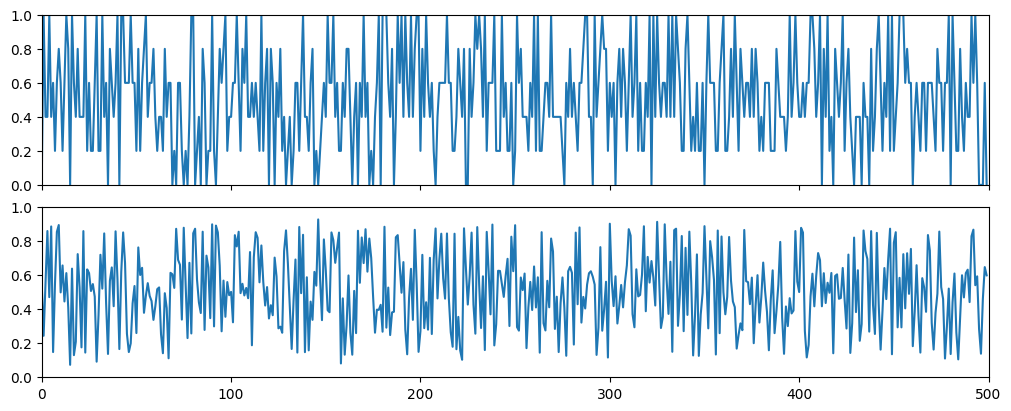

In [87]:
fig, axs = plt.subplots(2, 1, figsize = (10, 4), sharex = True, sharey = True)
fig.set_layout_engine('constrained')
axs = axs.flatten()

xmax = 500

axs[0].plot([oom_cont.observables.index(i) / (len(oom_cont.observables) - 1) for i in generation_cont.sequence[:xmax]])
axs[1].plot(generation_cont.sequence_cont[:xmax])

for ax in axs:
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, 1])

plt.show()

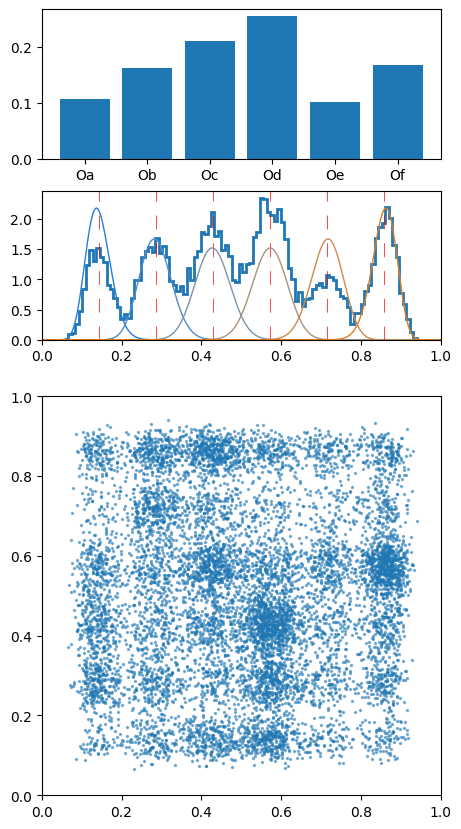

In [88]:
fig, axs = plt.subplots(3, 1, figsize = (4.5, 8.25), sharex = 'row', height_ratios = [1, 1, 3], layout = 'constrained')
axs = axs.flatten()

plot_sequence(axs, generation_cont, n_obs = len(oom_cont.observables))

plt.show()

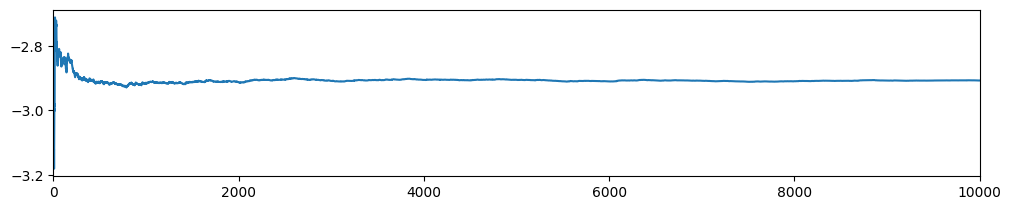

In [75]:
fig, ax = plt.subplots(1, 1, figsize = (10, 2))
fig.set_layout_engine('constrained')

ax.plot(generation_cont.nll_list)
ax.set_xlim([0, len(generation_cont.sequence)])

plt.show()

In [128]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return mpl.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [100]:
from sklearn.mixture import BayesianGaussianMixture

estimators = [
    BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components = 3,
        reg_covar = 0,
        covariance_type = 'full',
        init_params = "k-means++",
        # n_init = 3,
        max_iter = 1500,
        mean_precision_prior = 0.8,
        random_state = None, #0,
    ),
    BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components = 12,
        reg_covar = 0,
        covariance_type = 'full',
        init_params = "k-means++",
        # n_init = 3,
        max_iter = 1500,
        mean_precision_prior = 0.8,
        random_state = None, #0,
    ),
]

X = np.vstack([generation_cont.sequence_cont[:-1], generation_cont.sequence_cont[1:]]).T
y = generation_cont.sequence

for estimator in estimators:
    estimator.fit(X)

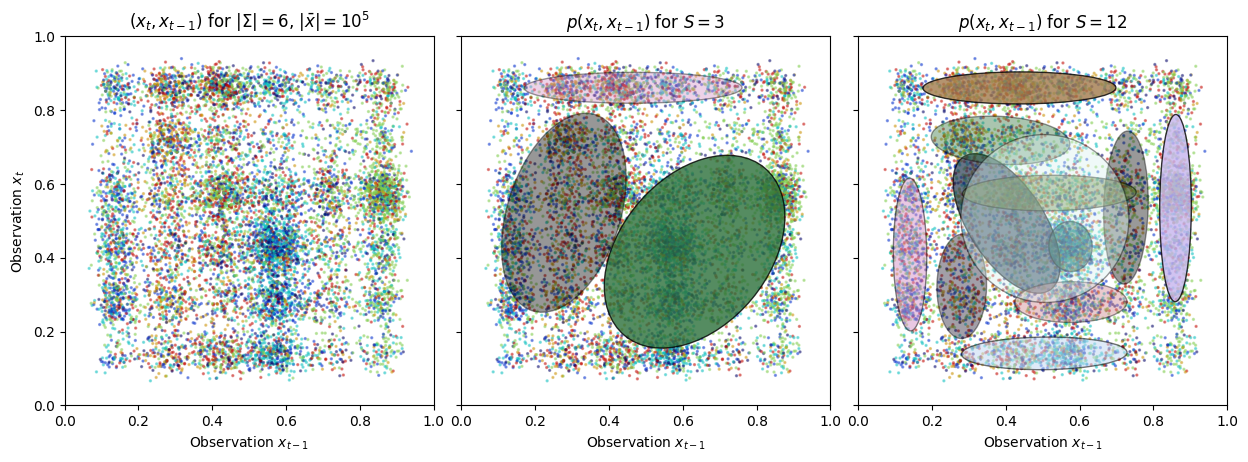

In [167]:
yind = [0.9 * oom_cont.observables.index(yi) / (len(oom_cont.observables) - 1) for yi in y]
cmap = cmap_map(lambda x: x*0.8, mpl.colormaps['jet'])
cmap2 = mpl.colormaps['cubehelix']

fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharex = True, sharey = True, gridspec_kw = {"hspace": 0, "wspace": 0.075, "width_ratios": [1, 1, 1]})#, 0.1]})

res0 = plot_results(
    axs[0],
    None,
    X = np.vstack([generation_cont.sequence_cont[:-1], generation_cont.sequence_cont[1:]]).T,
    y = yind,
    colors = cmap(yind),
    cmap = cmap2,
    title = r"$(x_t, x_{t-1})$ for $\vert \Sigma \vert = " + str(len(oom_cont.observables)) + r"$, $\vert \bar{x} \vert = 10^5$",
    xlab = r"Observation $x_{t-1}$",
    ylab = r"Observation $x_{t}$",
    return_data = True
)
plot_results(
    axs[1],
    estimators[0],
    X = np.vstack([generation_cont.sequence_cont[:-1], generation_cont.sequence_cont[1:]]).T,
    y = yind,
    colors = cmap(yind),
    cmap = cmap2,
    title = r"$p(x_t, x_{t-1})$ for $S = " + str(len(estimators[0].weights_)) + r"$",
    xlab = r"Observation $x_{t-1}$",
    ylab = None,
)
plot_results(
    axs[2],
    estimators[1],
    X = np.vstack([generation_cont.sequence_cont[:-1], generation_cont.sequence_cont[1:]]).T,
    y = yind,
    colors = cmap(yind),
    cmap = cmap2,
    title = r"$p(x_t, x_{t-1})$ for $S = " + str(len(estimators[1].weights_)) + r"$",
    xlab = r"Observation $x_{t-1}$",
    ylab = None,
)

# fig.colorbar(res0, cax = axs[3], orientation='vertical', use_gridspec = True)

plt.show()